# 4. Example: 4DVar Backprop DA using Reservoir Computing ML Model

In [1]:
import dabench as dab
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.sparse.linalg import bicgstab
from scipy.linalg import inv
from scipy.sparse.linalg import aslinearoperator
from copy import deepcopy
import jax.numpy as jnp
from jax import value_and_grad
from IPython.lib.deepreload import reload
import pickle

In [2]:
np_rng = np.random.default_rng(seed=50)

## A. Create Nature Run

In [3]:
train_size = 100000 
transient_size = 1000
test_size = 2000

In [4]:
# First define data generator and generate data
nature_run = dab.data.Lorenz96(system_dim=6, delta_t=0.01, store_as_jax=True)

In [5]:
nature_run.generate(n_steps=(train_size + transient_size + test_size))

In [6]:
nr_train, nr_transient, nr_test = nature_run.split_train_valid_test(train_size, transient_size, test_size)

## B. Generate Observations

In [7]:
# Now we can define the observer:
obs_l96 = dab.observer.Observer(
    nr_test, # Data generator object
    time_indices = np.arange(0, 2000, 5), # Observation every 5th timestep
    random_location_count = 6,
    error_bias = 0.0, 
    error_sd = 1.0, 
    random_seed=93,
    stationary_observers=True,
    store_as_jax=False
)

# Making observations
obs_vec_l96 = obs_l96.observe()

## C. Define and train model

In [8]:
# Define model
forecast_model = dab.model.RCModel(
    system_dim=6, 
    reservoir_dim=1600, 
    input_dim=6, 
    sparse_adj_matrix=False, 
    sparsity=0.99,
    readout_method='linear',
    sigma=0.07,
    spectral_radius = 0.1, 
    leak_rate=0.7,
    log_beta=-18.41)

In [9]:
# # Train: Takes a few minutes
# forecast_model.weights_init()
# forecast_model.train(nr_train)

In [10]:
# Shortcut: load the W_out weights from previous training
weights_path = 'rc_weights.pkl'
forecast_model.weights_init()
forecast_model.load_weights(weights_path)

## D. Set up and run DA Cycler

In [11]:
obs_total_size = 18
sigma_obs=0.1
sigma_bg = 0.05

H = forecast_model.Wout
R = sigma_obs* np.identity(obs_total_size)
B = sigma_bg*np.identity(forecast_model.reservoir_dim)


In [12]:
r0_original = forecast_model.update(forecast_model.generate(
        nr_transient.values
        + np.random.normal(size = (1000, nr_transient.system_dim), scale=0.05))[-1], nr_transient.values[-1])

In [13]:
num_epochs_per_cycle=20

In [14]:
dc = dab.dacycler.Var4DBackprop(
    system_dim=forecast_model.reservoir_dim,
    delta_t=nature_run.delta_t,
    H=H,
    B=B,
    R=R,
    learning_rate=1e-7,
    num_epochs=num_epochs_per_cycle,
    model_obj=forecast_model,
    obs_window_indices=[0,5,10],
    steps_per_window=11, # 11 instead of 10 because inclusive of 0 and 11
    )


Run the cycler

In [15]:
cur_tstep = 0

r0_sv = dab.vector.StateVector(
    values=r0_original,
    store_as_jax=True)

out_statevec = dc.cycle(
    input_state = r0_sv,
    start_time = nr_test.times[cur_tstep],
    obs_vector = obs_vec_l96,
    analysis_window=0.1,
    timesteps=198,
    obs_error_sd=sigma_obs,
    analysis_time_in_window=0.05)

CPU times: user 1min 40s, sys: 3.24 s, total: 1min 44s
Wall time: 1min 33s


In [16]:
analyses_stacked = forecast_model.readout(out_statevec.values)

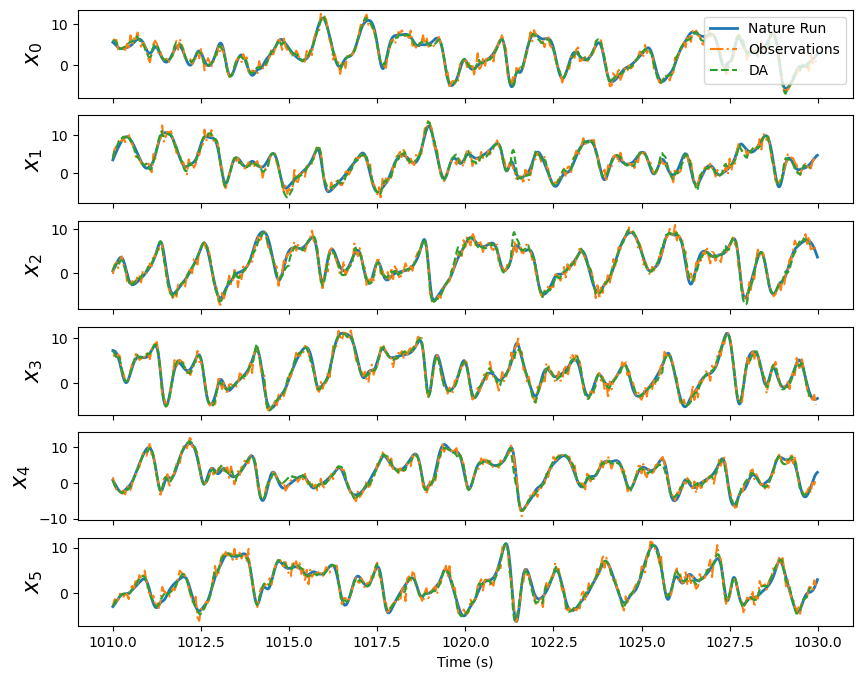

In [33]:
# Plot them all
fig, axes = plt.subplots(6, 1, sharex = True, figsize = (10, 8))
for j, ax in enumerate(axes):
    ax.plot(nr_test.times, nr_test.values[:, j], label='Nature Run', lw=2)
    ax.plot(obs_vec_l96.times, obs_vec_l96.values[:, j], label='Observations', lw=1.5, ls='-.')
    ax.plot(nr_test.times[:analyses_stacked.shape[0]], analyses_stacked[:, j],
            label='DA', ls='--', lw=1.5)
    ax.set_ylabel(r'$x_{:d}$'.format(j), fontsize = 16)
    if j ==0:
        ax.legend()
ax.set_xlabel('Time (s)')        
plt.show()